In [1]:
import matplotlib.pyplot as plt
import unidecode
import re
import pandas as pd
import pybootstrap as pb
import pymc3 as pm
from helper import *

In [3]:
#configure plotting
figures_path = '../figures/'
%matplotlib inline
plt.style.use('bmh')
plt.style.use('grayscale')


# Loading models

In [4]:
models_vk = load_models('vk', 10, align=True)
models_telegraaf = load_models('telegraaf', 10, align=True)
models_ah_nrc = load_models('ah_nrc', 10, align=True)
models_trouw = load_models('trouw', 10, align=True)
models_parool = load_models('parool', 10, align=True)
models_vv = load_models('vv', 10, align=True)

embeddings = [models_vk, models_telegraaf, models_ah_nrc, models_trouw,
                             models_parool, models_vv]
embedding_names = ['vk', 'telegraaf', 'nrc', 'trouw', 'parool', 'vv']
years = ['1950', '1960', '1970', '1980']
#years = ['1950', '1955', '1960', '1965', '1970', '1975', '1980','1985']

In [5]:
# Load names from Meertens Voornamenbank
names_df = pd.read_csv('../data/names/names.csv')
male_names = names_df['male_names'].apply(lambda x: unidecode.unidecode(x)).str.lower().values
female_names = names_df['female_names'].apply(lambda x: unidecode.unidecode(x)).str.lower().values

In [6]:
# Definite male and female referents
male_words = ['hij','vader', 'opa', 'zoon', 'man', 'mannen', 'heer']
female_words = ['zij', 'moeder', 'oma', 'dochter', 'vrouw', 'vrouwen', 'dame']

In [7]:
#Combination of names and referents
male_x = male_words + list(male_names)
female_x = female_words + list(female_names)

In [8]:
'''
lists of jobs from HISCO dataset
'''
hisco = pd.read_csv('../data/hisco/hsn2013a_hisco_comma.csv')
hisco['len'] = hisco['Standard'].str.split().apply(lambda x: len(x))
job_titles = hisco[hisco['len'] == 1]['Standard'].drop_duplicates().values
print("length jobs: {}".format(len(job_titles)))

length jobs: 12673


In [9]:
'''
Emotions with polarities from Cornetto
'''

emotions = pd.read_csv('../data/cornetto/emotion_cornetto.csv')
emotions.drop_duplicates(subset=['word'], keep='first', inplace=True)
#emotions = emotions[emotions['polarity'] != 0]

emotions['word'] = emotions['word'].apply(lambda x: unidecode.unidecode(x))
emotion_words = emotions[emotions['confidence'] == 1.0]['word'].values

In [10]:
pos_words = emotions[emotions['polarity'] >= 0.5]['word'].values
neg_words = emotions[emotions['polarity'] <= -0.5]['word'].values
print("length positive_words: {}".format(len(pos_words)))
print("length negative_words: {}".format(len(neg_words)))

length positive_words: 476
length negative_words: 636


Selected the following categories
* Psychological Processes
    * Affective or Emotional Processes
        * Positive emotions
            * Positive feelings
            * Optimism and energy
        * Negative emotions
            * Anxiety or feat
            * Anger
            * Sadness or depression
    * Cognitive mechanisms
        * Insight
        * Causation
        * Discrepancy
        * Tentative
        * Certainty
        * Inhibition
    * Sensory and Perceptual Process
        * Seeing
        * Hearing
        * Feeling
    * Social Processes
        * Communication
        * Other references to people
        * Friends
        * Family
        * Humans
* Personal Concerns
    * Occupation
        * School
        * Job or work
        * Achievement
    * Leisure 
        * Home
        * Sports
        * Television and movies
        * Music
    * Money and financial issues
    * Metaphysical issues
        * Religion
        * Death and dying
    * Physical states and function
        * Body states, symptoms
        * Sex and sexuality
        * Eating, drinking, dieting
        * Sleeping, dreaming
        * Grooming

In [11]:
'''
Dutch translation of LIWC 2001
'''
LIWC = pd.read_csv('../data/LIWC/LIWC_Dutch.csv')
for col in LIWC.columns:
    try:
        LIWC[col] = LIWC[col].astype(str).apply(lambda x: unidecode.unidecode(x)).values
        LIWC[col] = LIWC[col].astype(str).map(lambda x: x.rstrip('*'))
    except:
        pass

# list of all LIWC words
LIWC_list = []
for col in LIWC.columns:
    sublist = LIWC[col].dropna().tolist()
    for word in sublist: 
        word = re.sub("\*", '', word)
        LIWC_list.append(word)

selected_cols = ['Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 
                 'Senses', 'Social', 'Occup', 'Leisure', 'Home', 'Sports', 'TV',
                 'Music', 'Money', 'Metaph','Physcal','Body','Sexual', 'Eating', 'Sleep', 'Groom']
LIWC = LIWC[selected_cols]

# Frequency

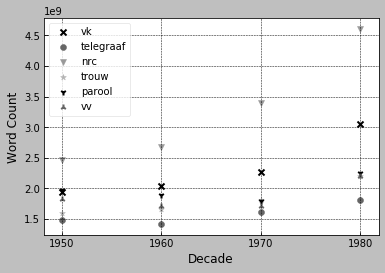

In [38]:
fmts = ['x', 'o', 'v', '*', '1', '2', '3']
for i, model in enumerate(embeddings):  
    model_name = embedding_names[i]
    counts = []
    for m in model:
        count = 0
        for word in m.vocab.keys():
            count += m.vocab[word].count
        counts.append(count)
    plt.scatter(years, counts, label=model_name, marker=fmts[i])
#plt.yscale('log')
#plt.title("Vocabulary Size per Embedding")
plt.xlabel('Decade')
plt.ylabel('Word Count')
plt.legend()
plt.savefig(figures_path + 'vocab_size.pdf', dpi=600)

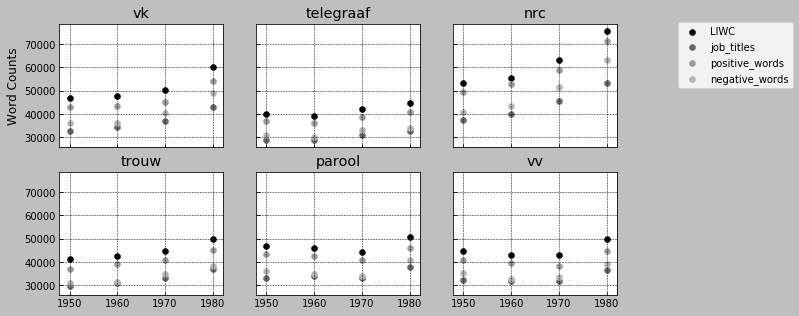

In [16]:
seeds_ = [LIWC_list, job_titles, pos_words, neg_words]
seed_names = ['LIWC', 'job_titles', 'positive_words', 'negative_words']


fig, axis = plt.subplots(2, 3, figsize=(10, 5), sharey=True, sharex=True)
axis = axis.ravel()

for i, model in enumerate(embeddings):
    model_name = embedding_names[i]
    counts_list = {}
    for name, list_ in zip(seed_names, seeds_):
        counts_avg = []
        for m in model:
            counts = []
            for word in list_:
                try:
                    counts.append(m.vocab[word].count)
                except: 
                    pass
            counts_avg.append(np.mean(counts))
        counts_list[name] = counts_avg

    for name in seed_names:
        axis[i].scatter(years, counts_list[name], label=name)
        axis[i].set_title(model_name)
        
    if not i%6:
        
        axis[i].set_ylabel('Word Counts')
plt.legend(bbox_to_anchor=(2.1, 2.25), loc='upper right', ncol=1)
plt.savefig(figures_path + 'target_words_count.pdf')

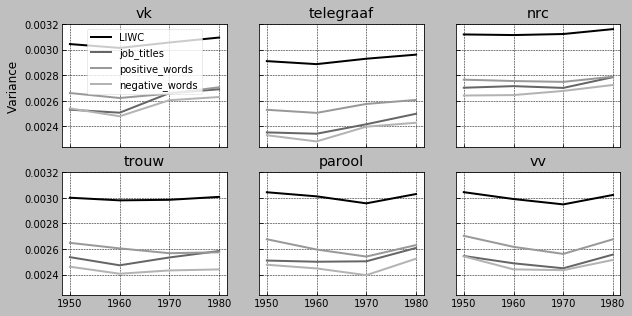

In [17]:
fig, axis = plt.subplots(2, 3, figsize=(10, 5), sharey=True, sharex=True)
axis = axis.ravel()

for i, model in enumerate(embeddings):
    model_name = embedding_names[i]
    counts_list = {}
    for name, list_ in zip(seed_names, seeds_):
        counts_avg = []
        for m in model:
            counts = []
            for word in list_:
                try:
                    counts.append(m[word])
                except: 
                    pass
            counts_avg.append(np.mean(np.var(counts, axis=0)))
        counts_list[name] = counts_avg

    for name in seed_names:
        axis[i].plot(years, counts_list[name], label=name)
        axis[i].set_title(model_name)
    if not i%6:
        axis[i].legend()
        axis[i].set_ylabel('Variance')
plt.savefig(figures_path + 'variance.pdf')

## Employment Netherlands

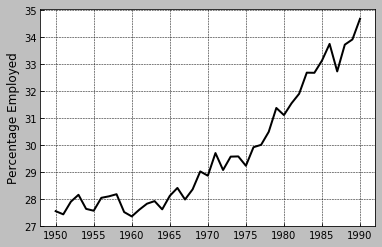

In [18]:
employment = pd.read_csv('../data/beroepsbevolking/Beroepsbevolking_1800_2013.csv', sep=';')
employment['beroepsbevolking'] = employment['Werkzame beroepsbevolking/Werkzame beroepsbevolking (x 1 000)']

#group by decade
#male_employment = employment[employment['Geslacht'] == 'Mannen'].groupby((employment['Perioden']//10)*10).sum()['beroepsbevolking'].values[:-1]
#female_employment = employment[employment['Geslacht'] == 'Vrouwen'].groupby((employment['Perioden']//10)*10).sum()['beroepsbevolking'].values[:-1]

male_employment = employment[employment['Geslacht'] == 'Mannen']['beroepsbevolking'].values
female_employment = employment[employment['Geslacht'] == 'Vrouwen']['beroepsbevolking'].values

p = female_employment/(male_employment + female_employment) * 100
#logit_prop = np.log(p/(1-p))
plt.ylabel("Percentage Employed")
#plt.xlabel("Years")
#plt.title("Female Employment Numbers")
plt.plot(range(1950,1991),p)
plt.savefig(figures_path + 'female_employment.pdf')

# BIAS

Taken from Garg et al. <br>
More generally, we compute the representative group vector by taking the average of the vectors for each word in the given gender/ethnicity group. Then we compute the average Euclidean distance between each repre- sentative group vector and each vector in the neutral word list of interest, which could be occupations or adjectives. The difference of the average distances is our metric for bias—we call this the relative norm difference or simply embedding bias.

In [19]:
def plot_bias(list1, list2, target_words, name):
    plt.clf()
    for index, model in enumerate(embeddings):
        fmts = ['x', 'o', 'v', '.', '*', '1', '2', '3']
        C, means, bounds = embedding_bias(list1, list2, target_words, model)
        x = range(1950 + index, 1990 + index, 10)
        y = np.array(means)
        bounds = np.array(bounds).T
        errors = np.zeros_like(bounds)
        errors[0,:] = y - bounds[0,:]
        errors[1,:] = bounds[1,:] - y
        plt.errorbar(x, y=means, yerr=errors, fmt=fmts[index], label=embedding_names[index])
        plt.ylabel('Embedding Bias')
        #plt.ylim(-0.1, 0.1)
        plt.legend()
        plt.savefig(figures_path + 'mean_bias_{}.pdf'.format(name))

In [20]:
def embedding_bias(list1, list2, features, models):
    means = []
    bounds = []
    values = []
    year = []
    for index, model in enumerate(models):       
        v1 = np.mean([model[word] for word in list1 if word in model.vocab], axis=0)
        #v = calculate_vectors(model, male_words, female_words)
        v2 = np.mean([model[word] for word in list2 if word in model.vocab], axis=0)
        x = []
        y = []
        for word in features:
            try:
                x.append(calc_distance_between_vectors(v1, model[word]))
                y.append(calc_distance_between_vectors(v2, model[word]))
            except:
                pass
        C = [x_ - y_ for x_, y_ in zip(x, y)]
        values.append(C)
        means.append(np.mean(C))
        bounds.append(pb.bootstrap(C, confidence=0.95, iterations=1000, sample_size=.9, statistic=np.mean))
    return values, means, bounds

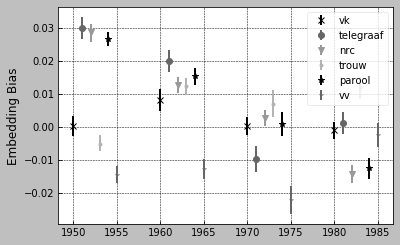

In [19]:
# for col in LIWC.columns:
#     name = str(col)
#     plot_bias(male_x, female_x, LIWC[col], name)

names = ['job_titles', 'pos_words', 'neg_words']

for index, group in enumerate([job_titles, pos_words, neg_words]):
    plot_bias(male_x, female_x, group, names[index])


## Calculate distances

In [21]:
def calculate_distances(list1, list2, target_words):
    distance_m = []
    distance_f = []
    titles_ = []
    years_ = []
    variances = []
    words = []
    counts = []
    for index, models in enumerate(embeddings):
        title = embedding_names[index]
        for i, model in enumerate(models):
            variance = []
            year = years[i]
            v_male = calculate_vector(model, list1)
            v_female = calculate_vector(model, list2)
            x = []     
            for word in target_words:
                #if word not in male_words and word not in female_words:
                try:
                    distance_m.append(calc_distance_between_vectors(v_male, model[word]))
                    distance_f.append(calc_distance_between_vectors(v_female, model[word]))
                    variance.append(model[word])
                    counts.append(model.vocab[word].count)
                    words.append(word)
                    years_.append(year)
                    titles_.append(title)
                #y.append(cossim(v2, model[word]))
                except:
                    pass
    df = pd.DataFrame(list(zip(distance_m, distance_f, words, counts, years_, titles_)), columns=['distance_m', 'distance_f', 'words', 'counts', 'years', 'titles'])
    df['bias'] = df['distance_m'] - df['distance_f']
    df['years'] = df['years'].astype(int)
    df['years.s'] = (df['years'] - df['years'].mean()) / df['years'].std()
    df['bias.s'] = (df['bias'] - df['bias'].mean()) / df['bias'].std()
    df['counts_log'] = np.log(df['counts'])
    df['counts.s'] = (df['counts_log'] - df['counts_log'].mean()) / df['counts_log'].std()
    df['total'] = df['counts'].groupby(df['years']).transform('sum')
    df['total.s'] = (df['total'] - df['total'].mean()) / df['total'].std()
    df['years.c'] = df['years'].replace([1950, 1960, 1970, 1980], [0, 1, 2, 3])
    #remove low frequent words
    df = df[df['counts'] >= 10**4]
    return df

# Model Comparison

In [22]:
df = calculate_distances(male_x, female_x, job_titles)

In [22]:
with pm.Model() as model_a:
    '''
    Model with only intercept
    '''
    a = pm.Normal('a', mu=0, sd=2)
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', a)
    bias = pm.Normal('Distance', mu=mu, sd=sigma, observed=df['bias.s'])
    trace_a = pm.sample(samples=5000, tune=1500, chains=4)

with pm.Model() as model_b:
    '''
    Model with years
    '''
    a = pm.Normal('a', mu=0, sd=2)
    bY = pm.Normal('bY', mu=0, sd=2)
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', a + bY * df['years.c'])
    bias = pm.Normal('Distance', mu=mu, sd=sigma, observed=df['bias.s'])
    trace_b = pm.sample(samples=5000, tune=1500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1543.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bY, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:08<00:00, 993.13draws/s] 


/usr/local/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


\begin{tabular}{lrrrrrrr}
\toprule
{} &   mean &     sd &  mc\_error &  hpd\_2.5 &  hpd\_97.5 &     n\_eff &   Rhat \\
\midrule
a     & -0.163 &  0.011 &       0.0 &   -0.186 &    -0.143 &   929.675 &  1.000 \\
bY    &  0.045 &  0.006 &       0.0 &    0.034 &     0.058 &   835.841 &  0.999 \\
sigma &  1.001 &  0.005 &       0.0 &    0.991 &     1.009 &  1398.385 &  0.999 \\
\bottomrule
\end{tabular}



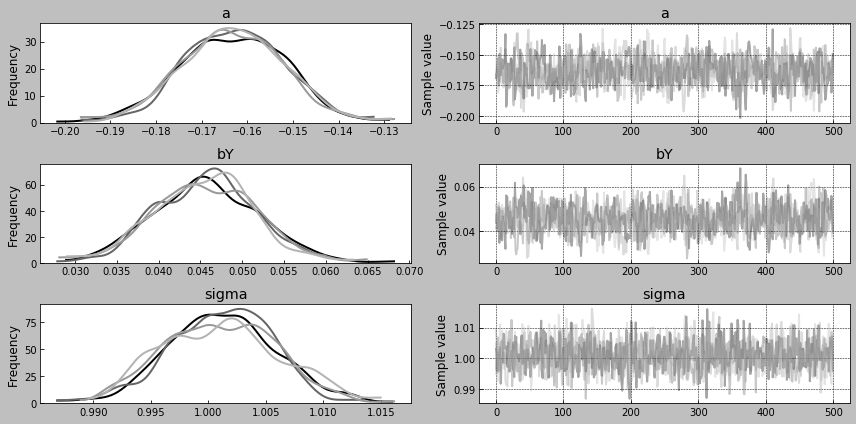

In [23]:
varnames = ['a', 'bY', 'sigma']
pm.traceplot(trace_b, varnames);
print(pm.summary(trace_b, varnames).round(3).to_latex())

In [24]:
comp_df = (pm.compare({
    model_a: trace_a,
    model_b: trace_b,

}).rename({0: "Model A",
           1: "Model B",
             }))
print(comp_df.to_latex())

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/usr/local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


\begin{tabular}{llllllll}
\toprule
{} &     WAIC & pWAIC &  dWAIC & weight &      SE &   dSE & var\_warn \\
\midrule
Model B &  64624.9 &  2.94 &      0 &   0.99 &  201.53 &     0 &        0 \\
Model A &  64682.1 &  1.93 &  57.26 &   0.01 &  201.36 &  15.2 &        0 \\
\bottomrule
\end{tabular}



# Bayesian Linear Regression

In [23]:
def make_linear_model(df, samples=5000, tune=1500, chains=4):
    with pm.Model() as model:
        a = pm.Normal('a', mu=0, sd=2)
        bY = pm.Normal('bY', mu=0, sd=2)
        #bC = pm.Normal('bC', mu=0, sd=2)
        sigma = pm.HalfCauchy('sigma', beta=1)
        mu = pm.Deterministic('mu', a + bY * df['years.c'])
        bias = pm.Normal('Distance', mu=mu, sd=sigma, observed=df['bias.s'])
        trace = pm.sample(progressbar=False, samples=samples, tune=tune, chains=chains)      
    return trace

def plot_linear(trace, name):
    plt.clf()
    seq_x = np.arange(-.5, 3.5, 0.05)
    mu_pred = np.zeros((len(seq_x), len(trace['bY'])))
    for i_seq, seq in enumerate(seq_x):
        mu_pred[i_seq] = trace['a'] + trace['bY'] * seq_x[i_seq]

    mu_mean = mu_pred.mean(1)
    mu_hpd = pm.hpd(mu_pred.T, alpha=0.05)

    plt.scatter(df['years.c'], df['bias.s'], facecolors='none', edgecolors='grey')
    plt.plot(seq_x, mu_mean, 'C0')
    plt.xticks([0, 1, 2, 3], years, rotation=45)
    plt.fill_between(seq_x, mu_hpd[:,0], mu_hpd[:,1], color='C0', alpha=0.3)
    plt.ylabel('Bias (m - / f +)')
    plt.ylim(-5, 5)
    #plt.xticks(np.arange(1950, 1980, 10))
    plt.xlabel('Years', fontsize=14);
    #plt.title(name)
    plt.savefig(figures_path + 'combined_{}.pdf'.format(name))

In [28]:
varnames = ['a', 'bY']

## Combined Linear Model

In [26]:
#targets_ = [pos_words, neg_words, job_titles]
#names = ['positive_words', 'negative_words', 'job_titles']
varnames = ['a', 'bY']
summary_combined = {}
for i, target in enumerate(targets_):
    name = names[i]
    print(name)
    df = calculate_distances(male_x, female_x, target)

    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    
    trace = make_linear_model(df, chains=1)
    summary_combined[name] = pm.summary(trace, varnames).round(3)
    plot_linear(trace, name)

NameError: name 'targets_' is not defined

Affect


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Posemo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Negemo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Anx


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Anger


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sad


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Senses


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Social


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Occup


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Leisure


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Home


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sports


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


TV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Music


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Money


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Metaph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Physcal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Body


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sexual


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Eating


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sleep


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Groom


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


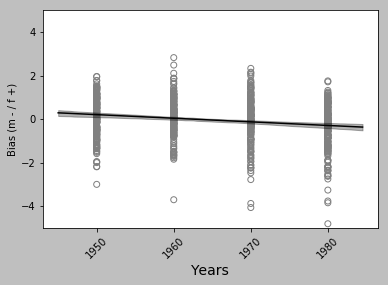

In [32]:
for col in LIWC.columns:
    name = str(col)
    print(name)
    df = calculate_distances(male_x, female_x, LIWC[col])
    
    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    try:
        trace = make_linear_model(df, chains=1)
        summary_combined[name] = pm.summary(trace, varnames).round(3)
        plot_linear(trace, name)
    except:
        pass
  
    

In [ ]:
model_summary = pd.concat(summary_combined.values(), keys=summary_combined.keys())
model_summary.drop(['mc_error'], axis=1, inplace=True)
print(model_summary.to_latex())

# print(df.loc[['TV', 'Sexual', 'Occup', 'occupations', 
#               'negative_words', 'Occupations', 'TV', 'Music', 'Money', 
#               'Metaph', 'Groom']].to_latex())

### Individual Newspapers

In [26]:
def individual_newspapers(df, sample=5000, tune=1500, chains=1):
    summary_individual = {}
    indiv_traces = {}

    for newspaper in newspaper_names:
        c_data = df.loc[df['titles'] == newspaper]
        c_data = c_data.reset_index(drop=True)

        c_bias = c_data['bias.s']
        c_years = c_data['years.c'].values
        c_counts = c_data['counts.s'].values

        with pm.Model() as individual_model:
            a = pm.Normal('a', mu=0, sd=2)
            bY = pm.Normal('bY', mu=0, sd=2)
            #bc = pm.Normal('beta_c', mu=0, sd=1)
            sigma = pm.HalfCauchy('eps', beta=1)

            #bias_est = a + b * c_years + bc * c_counts
            bias_est = a + bY * c_years
            y_like = pm.Normal('y_like', mu=bias_est, sd=sigma, observed=c_bias)

            trace = pm.sample(progressbar=False, sample=sample, tune=tune, chains=chains)
        indiv_traces[newspaper] = trace
        summary_individual[newspaper] = pm.summary(trace, varnames).round(3)
    return indiv_traces, summary_individual

In [36]:
def plot_individual_traces(traces, name):
    plt.clf()
    fig, axis = plt.subplots(3, 2, figsize=(10, 15), sharey=True, sharex=False)
    axis = axis.ravel()
    for i, c in enumerate(newspaper_names):
        c_data = df.loc[df['titles'] == c]
        c_data = c_data.reset_index(drop = True)
        z = list(c_data['newspaper_id'])[0]

        xvals = np.linspace(-0.5, 3.5)
        for a_val, b_val in zip(traces[c]['a'][::20], 
                                        traces[c]['bY'][::20]
                                        ):
            axis[i].plot(xvals, a_val + b_val * xvals, 
                         'grey', alpha=.2)

        axis[i].plot(xvals, traces[c]['a'][::10].mean() + 
                     traces[c]['bY'][::10].mean() * xvals, 
                     'black', alpha=1, lw=2., label='Regressions')
        axis[i].scatter(c_data['years.c'].values + 
                        np.random.randn(len(c_data))*0.01, 
                        c_data['bias.s'], alpha=1, color='k', 
                        marker='.', s=80, label='original data')
        axis[i].set_xticks([0, 1, 2, 3])
        axis[i].set_xticklabels(years, rotation=45)
        axis[i].set_ylim(-5, 5)
        axis[i].set_title(c)
        if not i%6:
            axis[i].legend()
            axis[i].set_ylabel('Bias (m - / f +)')
        #fig.suptitle(name)
        plt.savefig(figures_path + 'indiv_{}.pdf'.format(name), dpi=600)

In [29]:
summaries = {}
for col in LIWC.columns:
    name = str(col)
    print(name)
    df = calculate_distances(male_x, female_x, LIWC[col])
    
    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    
    traces, summary = individual_newspapers(df, chains=1)
    summaries[name] = summary
    plot_individual_traces(traces, name)

Affect


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Only one chain was sampled, this makes it impossible to run some convergence checks


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

Sexual


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

<Figure size 432x288 with 0 Axes>

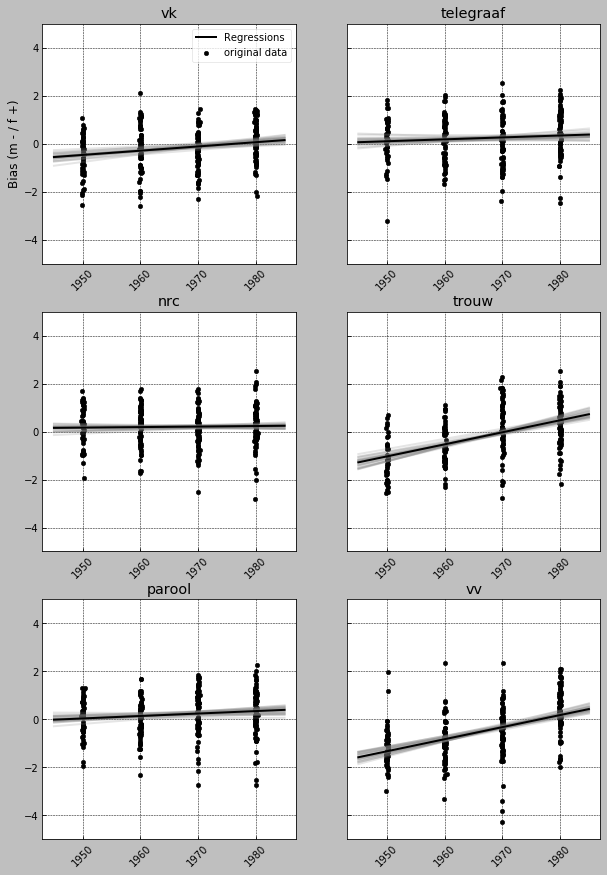

In [37]:
# targets_ = [pos_words, neg_words, job_titles]
# names = ['positive_words', 'negative_words', 'job_titles']
targets_ = [LIWC['Sexual']]
names = ['Sexual']
for i, target in enumerate(targets_):
    name = names[i]
    print(name)
    df = calculate_distances(male_x, female_x, target)

    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    
    traces, summary = individual_newspapers(df, chains=1)
    summaries[name] = summary
    plot_individual_traces(traces, name)

In [ ]:
models = []
categories = list(LIWC.columns.values) + names
for category in categories: 
    temp_df = pd.concat(summaries[category].values(), keys=summaries[category].keys())
    temp_df['category'] = category
    temp_df.drop(['mc_error'], axis=1, inplace=True)
    models.append(temp_df)
model_summary_indiv = pd.concat(models)
print(model_summary_indiv.sort_index().to_latex())

In [ ]:
model_summary_indiv

In [ ]:
bY = model_summary_indiv.loc[(model_summary_indiv.index.get_level_values(level=1) == 'bY')].sort_index()

In [ ]:
bY.loc[(bY['hpd_2.5'] < 0.00) &(bY['hpd_97.5'] > 0.00)]

In [ ]:
pos = bY.loc[bY['hpd_2.5'] > 0.00]
neg = bY.loc[bY['hpd_97.5'] < 0.00]
equal = bY.loc[(bY['hpd_2.5'] < 0.00) &(bY['hpd_97.5'] > 0.00)]


In [ ]:
total = bY.groupby([bY.index.get_level_values(0)])['mean'].count()
print(total)
print('----')
pos_change = pos.groupby([pos.index.get_level_values(0)])['mean'].count()
print(pos_change)
print('----')
neg_change = neg.groupby([neg.index.get_level_values(0)])['mean'].count()
print(neg_change)
print('----')
no_change = equal.groupby([equal.index.get_level_values(0)])['mean'].count()
print(no_change)

In [ ]:
pd.concat(neg_change, pos_change)

## Inspect Bias

In [35]:
import random
def plot_differences(list1, list2, model, features):
    features = [word for word in features if word in model.vocab]
    v1 = np.mean([model[word] for word in list1 if word in model.vocab], axis=0)
    v2 = np.mean([model[word] for word in list2 if word in model.vocab], axis=0)
    x = []
    y = []
    for word in features:
        x.append(calc_distance_between_vectors(model[word], v1))
        y.append(calc_distance_between_vectors(model[word], v2))
    C = [x_ - y_ for x_, y_ in zip(x, y)]
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.xlabel('distance to male')
    plt.ylabel('distance to female')
    plt.ylim(min(y) - 0.05, max(y) + 0.05)
    plt.xlim(min(y) - 0.05, max(y) +0.05)
    top_idx = random.sample(list(np.argsort(C)[-50:]), 20)
    bottom_idx = random.sample(list(np.argsort(C)[:50]), 20)
    for i, label in enumerate(features):
        if i in top_idx or i in bottom_idx:
            ax.annotate(label, (x[i], y[i]))
    ax.plot([min(y) -0.05, max(x) +0.15], [min(y) -0.05, max(x) + 0.05], ls="--", c=".3")

    plt.savefig(figures_path + 'example_jobs.pdf', dpi=600)
    return C, top_idx

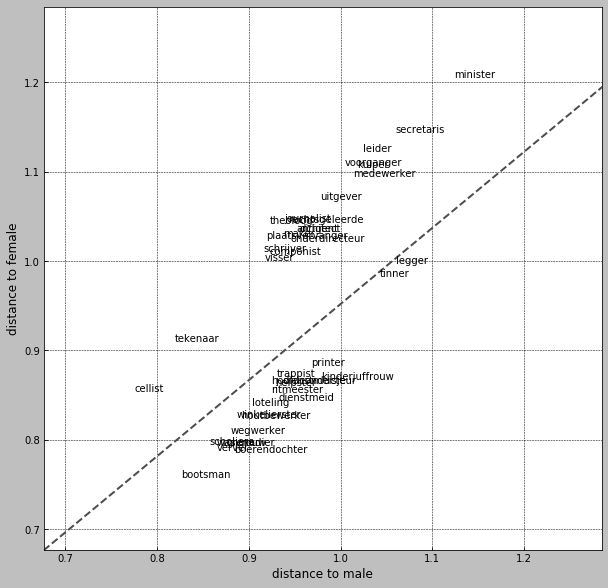

In [34]:
plot_differences(male_x, female_x, models_vk[2], job_titles);

In [ ]:
random.sample(list(top_idx), 10)

In [ ]:
top_idx